# Recovery of gold from ore

Prototype a machine learning model for a company that develops industrial efficiency solutions.

The model should predict the recovery rate of gold from gold ore. We have data with extraction and purification parameters.

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

The key steps of our project will be:

* Loading and preparing data
* Verification of enrichment efficiency calculation
* Analysis of features not available in the test sample
* Data preprocessing
* Analysis of the concentrations of different metals at various stages of purification
* Comparison of the size distribution of raw material granules on the training and test samples
* Study of the total concentration of all substances at different stages
* Create a function to calculate the final sMAPE
* Training different models and testing their quality by cross-validation. Choose the best model.
  
The project is made in **Jupyter Notebook**, Notebook server version: 6.1.4. Version **Python** 3.7.8.
Libraries used in the project
* **Pandas**
* **NumPy**
* **scikit-learn**
* **IPython**

## Loading and preparing data

In [1]:
# Import all the required libraries and modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

# Read the data.
data = pd.read_csv('gold_recovery_full_new.csv')
train_data = pd.read_csv('gold_recovery_train_new.csv')
test_data = pd.read_csv('gold_recovery_test_new.csv')

def describe(data):
    print('Size of the table is', data.shape)
    print()
    data.info()
    pd.set_option('display.max_columns', None)
    display(data)
    print('Number of the row duplicates is', data.duplicated().sum())

describe(data)

Size of the table is (19439, 87)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                     

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Number of the row duplicates is 0


In [2]:
describe(train_data)

Size of the table is (14149, 87)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                     

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

Number of the row duplicates is 0


The size of the training sample is approximately 73% of the original dataset, which is quite acceptable.

In [3]:
describe(test_data)

Size of the table is (5290, 53)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

Number of the row duplicates is 0


It is necessary to give a definition to each feature, to order it. This will allow us to work more efficiently with the data. Let's get started.

**Date**  

`date` — date and time of reading 
  
**Flotation**  


*Design parameters*  

`rougher.calculation.sulfate_to_au_concentrate` - estimated concentration of sulfates added to gold at the flotation stage  
`rougher.calculation.floatbank10_sulfate_to_au_feed` - the estimated amount of raw material fed to flotation unit No. 10 for combining sulfate with gold  
`rougher.calculation.floatbank11_sulfate_to_au_feed` - the estimated amount of raw material fed to flotation unit No. 11 for combining sulfate with gold  
`rougher.calculation.au_pb_ratio` - estimated ratio of gold to lead at the flotation stage

*Input parameters*  

`rougher.input.feed_ag` - the amount of silver in the feed before the flotation stage  
`rougher.input.feed_pb` - the amount of lead in the feed before the flotation stage  
`rougher.input.feed_rate` - raw material feed rate before the flotation stage  
`rougher.input.feed_size` - the size of the raw material granules before the flotation stage  
`rougher.input.feed_sol` - the amount of salt in the feed before the flotation stage  
`rougher.input.feed_au` - the amount of gold in the raw material before the flotation stage  
`rougher.input.floatbank10_sulfate` - the amount of sulfate in the raw material located in the flotation plant No. 10, before the flotation stage  
`rougher.input.floatbank10_xanthate` - the amount of xanthate in the raw material in flotation unit No. 10 before the flotation stage  
`rougher.input.floatbank11_sulfate` - the amount of sulfate in the raw material located in the flotation plant No. 11, before the flotation stage  
`rougher.input.floatbank11_xanthate` - the amount of xanthate in the raw material located in the flotation unit No. 11, before the flotation stage
  
*Status during process*  
  
`rougher.state.floatbank10_a_air` - air volume in stage "a" in flotation unit #8 during flotation  
`rougher.state.floatbank10_a_level` - liquid level at stage "a" in flotation unit #8 during flotation  
`rougher.state.floatbank10_b_air` - air volume in stage "b" in flotation unit #8 during flotation  
`rougher.state.floatbank10_b_level` - liquid level at stage "b" in flotation unit #8 during flotation  
`rougher.state.floatbank10_c_air` - air volume in stage "c" in flotation unit #8 during flotation  
`rougher.state.floatbank10_c_level` - liquid level at stage "c" in flotation unit #8 during flotation  
`rougher.state.floatbank10_d_air` - air volume in stage "d" in flotation unit #8 during flotation  
`rougher.state.floatbank10_d_level` - liquid level at stage "d" in flotation unit #8 during flotation  
`rougher.state.floatbank10_e_air` is the air volume in stage "e" in flotation unit #8 during flotation  
`rougher.state.floatbank10_e_level` - liquid level at stage "e" in flotation unit #8 during flotation  
`rougher.state.floatbank10_f_air` - air volume in stage "f" in flotation unit #8 during flotation  
`rougher.state.floatbank10_f_level` - liquid level at stage "f" in flotation unit #8 during flotation 
  
*Output parameters*  
  
`rougher.output.concentrate_ag` - concentration of silver in the product after flotation  
`rougher.output.concentrate_pb` - concentration of lead in the product after flotation  
`rougher.output.concentrate_sol` - concentration of salts in the product after flotation  
`rougher.output.concentrate_au` - concentration of gold in the product after flotation  
`rougher.output.recovery` - efficiency of raw material enrichment after flotation  
`rougher.output.tail_ag` - mass of silver in tailings after flotation  
`rougher.output.tail_pb` - mass of lead in waste tailings after flotation  
`rougher.output.tail_sol` - mass of salts in tailings after flotation  
`rougher.output.tail_au` - weight of gold in tailings after flotation 
 
  
**Primary cleaning**  
  
*Input parameters* 

`primary_cleaner.input.sulfate` - the amount of sulfates at the stage of primary cleaning of raw materials  
`primary_cleaner.input.depressant` - the number of depressants at the stage of primary cleaning of raw materials `primary_cleaner.input.feed_size` - the size of the feed at the stage of primary cleaning of the feed  
`primary_cleaner.input.depressant` - the amount of xanthates at the stage of primary cleaning of raw materials
  
*Status during process*
  
`primary_cleaner.state.floatbank8_a_air` - air volume at stage "a" in flotation unit No. 8 during primary cleaning of raw materials  
`primary_cleaner.state.floatbank8_a_level` - liquid level at stage "a" in flotation unit No. 8 during primary cleaning of raw materials  
`primary_cleaner.state.floatbank8_b_air` - air volume at stage "b" in flotation unit No. 8 during primary cleaning of raw materials  
`primary_cleaner.state.floatbank8_b_level` - liquid level at stage "b" in flotation unit No. 8 during primary cleaning of raw materials  
`primary_cleaner.state.floatbank8_c_air` - air volume at stage "c" in flotation unit No. 8 during primary cleaning of raw materials  
`primary_cleaner.state.floatbank8_c_level` - liquid level at stage "c" in flotation unit No. 8 during primary cleaning of raw materials  
`primary_cleaner.state.floatbank8_d_air` - air volume at stage "d" in flotation unit No. 8 during primary cleaning of raw materials  
`primary_cleaner.state.floatbank8_d_level` - liquid level at stage "d" in flotation unit No. 8 during primary cleaning of raw materials   
  
*Output parameters*   
  
`primary_cleaner.output.concentrate_ag` - concentration of silver in the product after primary cleaning of raw materials  
`primary_cleaner.output.concentrate_pb` - final concentration of lead in the product after primary cleaning of raw materials  
`primary_cleaner.output.concentrate_sol` - final concentration of salts in the product after primary cleaning of raw materials  
`primary_cleaner.output.concentrate_au` - final concentration of gold in the product after primary cleaning of raw materials  
`primary_cleaner.output.tail_ag` - mass of silver in tailings after primary cleaning of raw materials  
`primary_cleaner.output.tail_pb` - mass of lead in waste tailings after primary cleaning of raw materials  
`primary_cleaner.output.tail_sol` - mass of salts in tailings after primary cleaning of raw materials  
`primary_cleaner.output.tail_au` - the amount of gold in tailings after primary cleaning of raw materials

  
**Secondary cleaning**  
  
*Status during process*  

`secondary_cleaner.state.floatbank2_a_air` is the air volume in stage "a" in flotation unit #2 during secondary cleaning
`secondary_cleaner.state.floatbank2_a_level` - liquid level at stage "a" in flotation unit #2 during secondary cleaning
`secondary_cleaner.state.floatbank2_b_air` - air volume in stage "b" in flotation unit #2 during secondary cleaning
`secondary_cleaner.state.floatbank2_b_level` - liquid level at stage "b" in flotation unit #2 during secondary cleaning
`secondary_cleaner.state.floatbank3_a_air` is the air volume in stage "a" in flotation unit #3 during secondary cleaning
`secondary_cleaner.state.floatbank3_a_level` - liquid level at stage "a" in flotation unit #3 during secondary cleaning
`secondary_cleaner.state.floatbank3_b_air` - air volume in stage "b" in flotation unit #3 during secondary cleaning
`secondary_cleaner.state.floatbank3_b_level` - liquid level at stage "b" in flotation unit #3 during secondary cleaning
`secondary_cleaner.state.floatbank4_a_air` is the air volume in stage "a" in flotation unit #4 during secondary cleaning
`secondary_cleaner.state.floatbank4_a_level` - liquid level at stage "a" in flotation unit No. 4 during secondary cleaning
`secondary_cleaner.state.floatbank4_b_air` - air volume in stage "b" in flotation unit #4 during secondary cleaning
`secondary_cleaner.state.floatbank4_b_level` - liquid level at stage "b" in flotation unit No. 4 during secondary cleaning
`secondary_cleaner.state.floatbank5_a_air` is the air volume in stage "a" in flotation unit #5 during secondary cleaning
`secondary_cleaner.state.floatbank5_a_level` - liquid level at stage "a" in flotation unit #5 during secondary cleaning
`secondary_cleaner.state.floatbank5_b_air` - air volume in stage "b" in flotation unit #5 during secondary cleaning
`secondary_cleaner.state.floatbank5_b_level` - liquid level at stage "b" in flotation unit No. 5 during secondary cleaning
`secondary_cleaner.state.floatbank6_a_air` is the air volume in stage "a" in flotation unit #6 during secondary cleaning
`secondary_cleaner.state.floatbank6_a_level` - liquid level at stage "a" in flotation unit No. 6 during secondary cleaning

*output parameters*

`secondary_cleaner.output.tail_ag` - mass of silver in tailings after secondary cleaning  
`secondary_cleaner.output.tail_pb` - mass of lead in tailings after secondary cleaning  
`secondary_cleaner.output.tail_sol` - mass of salts in tailings after secondary cleaning  
`secondary_cleaner.output.tail_au` - the amount of gold in tailings after secondary cleaning


**Final Specifications**

*output parameters*

`final.output.concentrate_ag` - final concentration of silver in the product  
`final.output.concentrate_pb` - final concentration of lead in the product  
`final.output.concentrate_sol` - final salt concentration in the product  
`final.output.concentrate_au` - final concentration of gold in the product  
`final.output.recovery` — final concentrate enrichment efficiency  
`final.output.tail_ag` - final mass of silver in dump tails  
`final.output.tail_pb` — final mass of lead in tailings  
`final.output.tail_sol` - final mass of salts in tailings  
`final.output.tail_au` - final mass of gold in dump tails 

## Verification of enrichment efficiency calculation

In [4]:
# Check on the training set that the efficiency
# enrichment calculated correctly.
# C is rougher.output.concentrate_au
# F is rougher.input.feed_au
# T is rougher.output.tail_au
# Let's write a function that calculates the enrichment efficiency.
# Then save the results of her work in a separate
# rougher.calculation.recovery column.
def recovery_calc(data):
    c = data['rougher.output.concentrate_au']
    f = data['rougher.input.feed_au']
    t = data['rougher.output.tail_au']
    recovery = ((c * (f - t)) / (f * (c - t))) * 100
    return recovery

train_data['rougher.calculation.recovery'] = train_data.apply(
    recovery_calc, axis=1
)
print(
    'The MAE between the calculated enrichment efficiency' +
    ' and the actual value is', mean_absolute_error(
        train_data['rougher.calculation.recovery'],
        train_data['rougher.output.recovery']
     )
)

The MAE between the calculated enrichment efficiency and the actual value is 9.73512347450521e-15


After calculating the MAE between the calculated enrichment efficiency and the actual value, we made sure that the `rougher.output.recovery` enrichment efficiency provided to us was calculated correctly.

## Analysis of features not available in the test sample

It can be seen that many features are missing in the test sample. We will identify the missing signs and try to determine the reason for their absence.
The test sample does not include:
* Features of the stage *final*. Fully.
* In the *rougher* stage, there are no calculated data of the *calculation* parameter, as well as product output data in the *output* parameter (including tailings)
* In the *primary_cleaner* stage, there is no product output data in the *output* parameter (including dump tailings)
* In the *secondary_cleaner* stage, there are no input and output data for raw materials and products in the *input* and *output* parameters, respectively (including tailings)
  
Having considered the features missing in the test sample, we can conclude that their absence is due to the task set before us. All types of data are present in the training set: both those that we know before the start of the process of obtaining gold from ore, and those that we receive during the process and after it. Our task is to build a model that will have to predict the recovery rate of gold from gold ore, based solely on input data that are known only before the start of the recovery process. Such a model will allow us to decide whether to launch a new production or not, focusing on the results of its work. The quality of the model, its work is evaluated in conditions that simulate reality. That is why the test sample should not have signs that reflect the process itself and its result.

## Data preprocessing

To start analyzing the data and building the model, we need to fill in the missing values that are present in the training dataset. Let's take care of this.

In [5]:
# Fill in the missing values in the columns using the fillna method.
# Since the values adjacent in time are similar to each other, we
# we can fill in the missing values with the previous adjacent value.
# To do this, use the ffill parameter.
# First, make sure the first row of the dataframe has no missing values.
display(train_data[:1].isna().sum(axis=1))
# Now replace missing values with neighboring values.
train_data = train_data.fillna(method='ffill')
# Replace the missing values in the test set.
test_data = test_data.fillna(method='ffill')
# Replace the missing values in the full set.
data = data.fillna(method='ffill')
# Let's make the date column as an index.
# This will come in handy later when testing models.
data = data.set_index('date')
train_data = train_data.set_index('date')
test_data = test_data.set_index('date')

0    0
dtype: int64

### Conclusion

We processed the data:
* Read and reviewed datasets. Checked their size. We checked them for complete duplicates.
* Gave a verbal definition of each feature in Russian.
* Checked on the training sample the correctness of the calculation of enrichment efficiency. This parameter is calculated correctly.
* Identified missing features in the test sample and explained why they are missing. They are missing because the model we have to create must make predictions based only on inputs known only prior to the start of the mining process.
* A critical part of preparing datasets for model building is getting rid of missing values. Since the parameters adjacent in time are often similar, we have replaced the `NaN`-values with the previous values.

The next step in the project will be data analysis. We are to:
* Consider how the concentration of metals changes at various stages of purification
* Compare the size distributions of raw material granules in the training and test samples
* Investigate the total concentration of all substances at different stages

## Data Analysis

### Analysis of the concentrations of different metals at various stages of purification

In [6]:
# Let's create a description function that allows you to quickly explore the values.
def description(table, parameter):
    table.plot(y=parameter, 
               kind='box', 
               grid=True, 
               figsize=(15,5)
              )
    plt.title('Boxplot for the '+ str(parameter) + ' column')
    plt.show()
    table.plot(y=parameter, 
          kind='hist', 
          grid=True, 
          bins=140, 
          figsize=(15,5)
         )
    plt.title('Histogram for the ' + str(parameter) + 
              ' bins number is 140')
    plt.show()
    display(table[parameter].describe())
    display(table[parameter].value_counts())

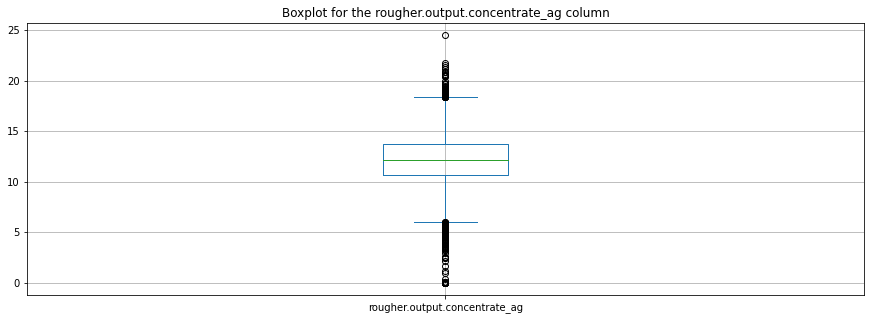

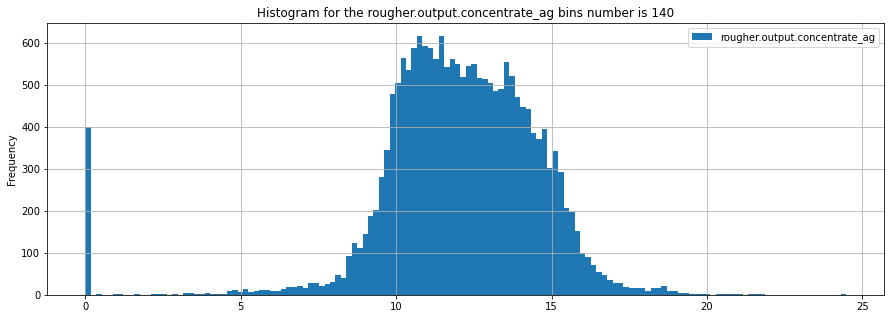

count    19439.000000
mean        11.994759
std          2.733862
min          0.000000
25%         10.628337
50%         12.098115
75%         13.736996
max         24.480271
Name: rougher.output.concentrate_ag, dtype: float64

0.000000     394
7.458753      11
9.975555       6
9.252737       6
0.010000       5
            ... 
12.045944      1
11.643920      1
11.509044      1
11.910939      1
11.959486      1
Name: rougher.output.concentrate_ag, Length: 19015, dtype: int64

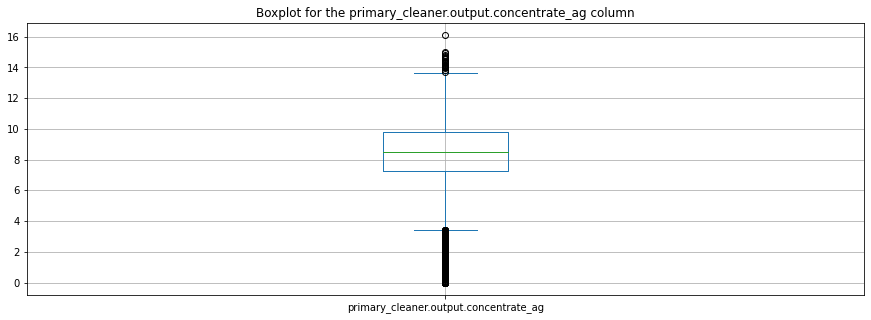

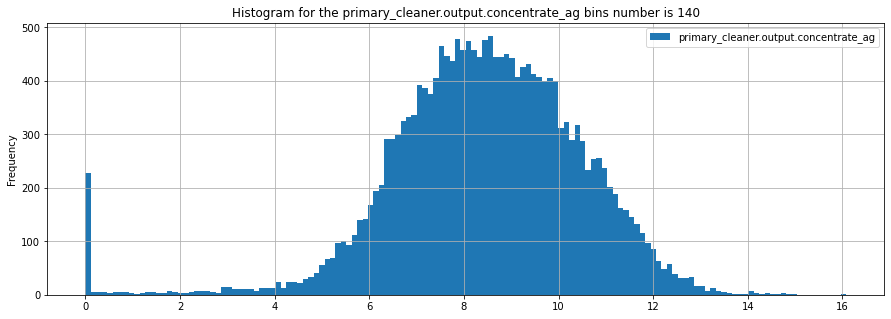

count    19439.000000
mean         8.442408
std          2.054465
min          0.000000
25%          7.263288
50%          8.507298
75%          9.809001
max         16.081632
Name: primary_cleaner.output.concentrate_ag, dtype: float64

0.010000     117
0.000000     108
8.339732       6
9.987871       5
7.925334       5
            ... 
11.985477      1
10.589469      1
10.479046      1
10.528766      1
7.537584       1
Name: primary_cleaner.output.concentrate_ag, Length: 19199, dtype: int64

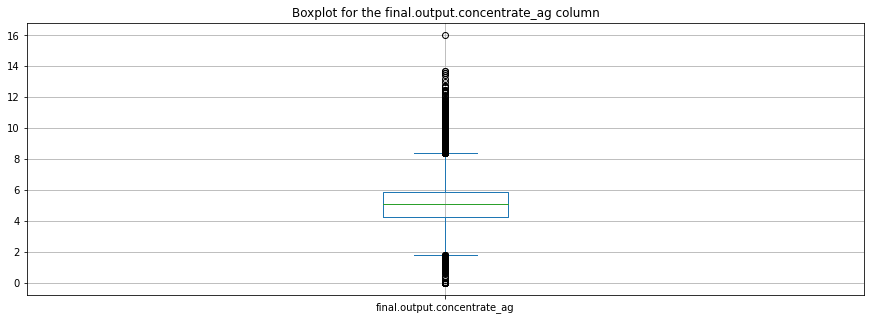

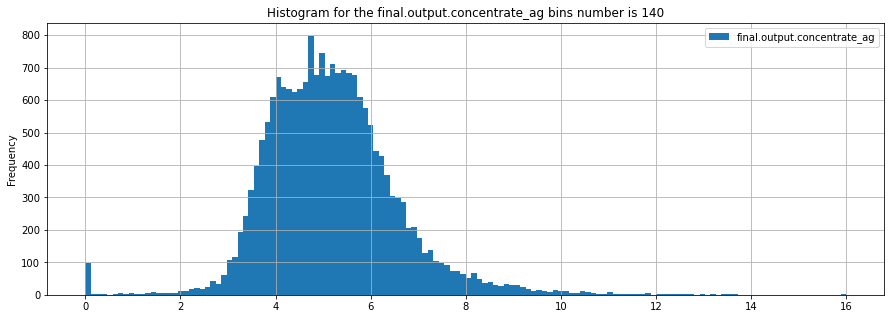

count    19439.000000
mean         5.168387
std          1.372362
min          0.000000
25%          4.251000
50%          5.066039
75%          5.895401
max         16.001945
Name: final.output.concentrate_ag, dtype: float64

0.000000    98
5.925380    11
3.554558     7
3.572025     6
5.955403     5
            ..
5.251861     1
5.541594     1
5.658072     1
5.931221     1
3.598375     1
Name: final.output.concentrate_ag, Length: 19307, dtype: int64

In [7]:
# Let's start by analyzing the concentration of silver at each stage.
parameters = [
    'rougher.output.concentrate_ag', 
    'primary_cleaner.output.concentrate_ag',          
    'final.output.concentrate_ag'
]
for element in parameters:
    description(data, element)

**Silver**  
At all stages, the silver concentration values are normally distributed. Each distribution has an anomaly in the form of peaks at zero values. For example, at the end of the *rougher* stage, we see 394 zero values of the silver concentration. At the same time, according to the results of the next stage (*primary_cleaner*), the concentration of silver in these lines is greater than zero. It can be assumed that the appearance of zeros is justified and due to the continuity of the ore enrichment process. For example, at the time of taking readings, a new batch of raw material simply has not yet gone through the flotation process.
  
*Consider concentrations:*
* Flotation. Median silver concentration: 12.1%
* Primary cleaning. Median silver concentration: 8.5%
* Final concentrate. Median silver concentration: 5.1%

In [8]:
# Record the results in a table.
ag_concentrate = pd.DataFrame(
    {
        'Flotation': [data['rougher.output.concentrate_ag'].median()], 
        'Primary cleaning': [
            data['primary_cleaner.output.concentrate_ag'].median()
        ], 
        'Final concentrate': [
            data['final.output.concentrate_ag'].median()
        ]
    }, 
    index=[
        'Median silver concentration'
    ]
)
display(ag_concentrate)

,Flotation,Primary cleaning,Final concentrate
Median silver concentration,12.098115,8.507298,5.066039


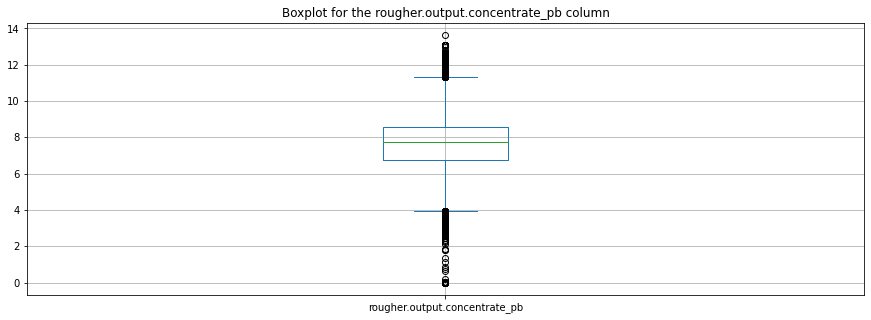

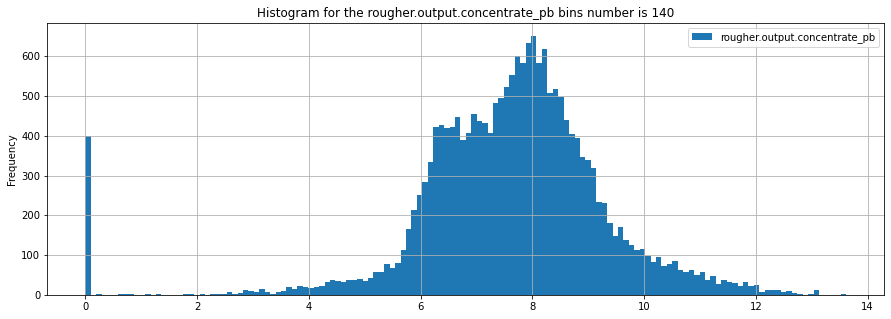

count    19439.000000
mean         7.606272
std          1.796757
min          0.000000
25%          6.725987
50%          7.742580
75%          8.565199
max         13.617072
Name: rougher.output.concentrate_pb, dtype: float64

0.000000     394
13.077148     11
8.452148       8
10.452148      7
7.944824       6
            ... 
6.676261       1
6.425157       1
6.550319       1
6.189836       1
10.702148      1
Name: rougher.output.concentrate_pb, Length: 18956, dtype: int64

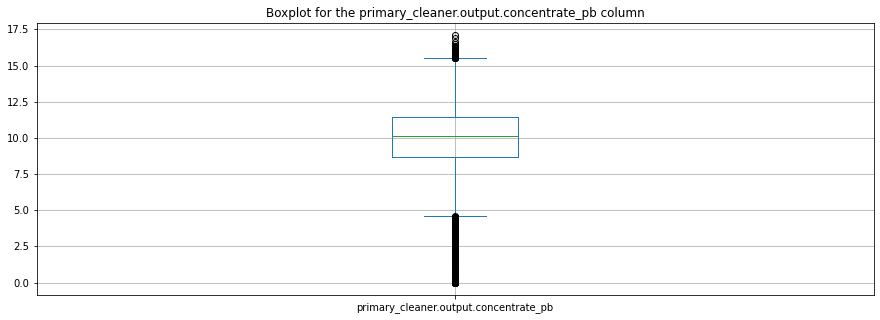

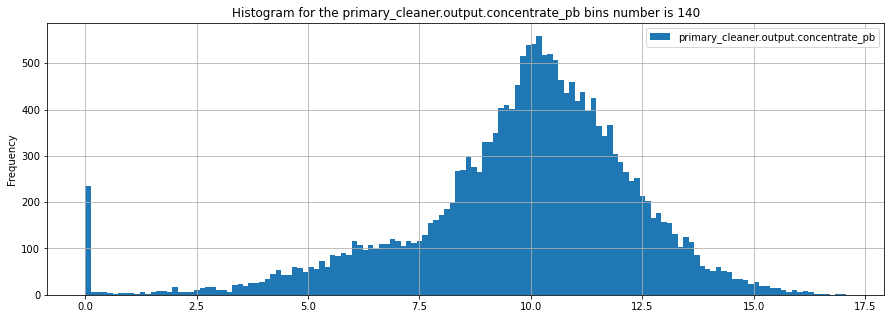

count    19439.000000
mean         9.810317
std          2.572253
min          0.000000
25%          8.676500
50%         10.142270
75%         11.416298
max         17.081278
Name: primary_cleaner.output.concentrate_pb, dtype: float64

0.010000     118
0.000000     114
5.055124       7
11.327148      6
5.587420       6
            ... 
7.551820       1
9.766251       1
7.646592       1
3.642507       1
11.650285      1
Name: primary_cleaner.output.concentrate_pb, Length: 19055, dtype: int64

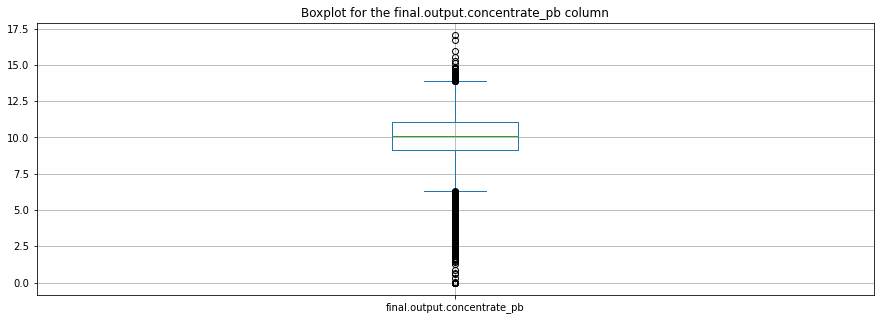

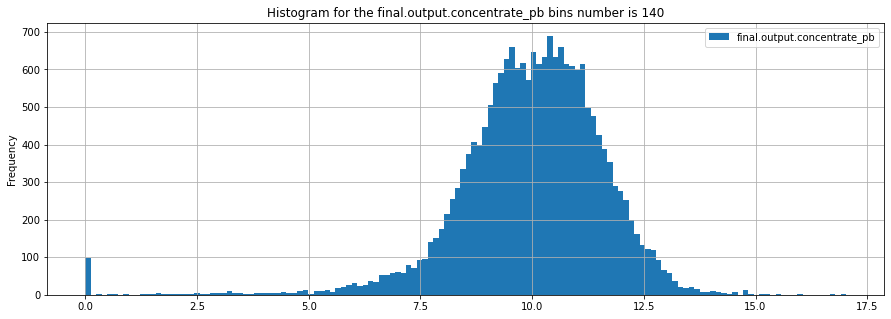

count    19439.000000
mean         9.978821
std          1.669228
min          0.000000
25%          9.137225
50%         10.102264
75%         11.035644
max         17.031899
Name: final.output.concentrate_pb, dtype: float64

0.000000     98
14.764648    11
11.452148     8
12.202148     7
9.389648      6
             ..
9.434807      1
9.228916      1
9.156048      1
9.151449      1
11.737832     1
Name: final.output.concentrate_pb, Length: 19276, dtype: int64

In [9]:
# Let's analyze the concentration of lead at each stage.
parameters = [
    'rougher.output.concentrate_pb', 
    'primary_cleaner.output.concentrate_pb',          
    'final.output.concentrate_pb'
]
for element in parameters:
    description(data, element)

**Plumbum**  
At all stages, lead concentrations are normally distributed. In each distribution, there is an anomaly in the form of peaks at zero values (as is the case with silver). It can be assumed that the appearance of zeros is justified and due to the continuity of the ore enrichment process. For example, at the time of taking readings, a new batch of raw material simply has not yet gone through the flotation process.
  
*Consider concentrations:*
* Flotation. Median lead concentration: 7.7%
* Primary cleaning. Median lead concentration: 10.15%
* Final concentrate. Median lead concentration: 10.1%
  
There are practically no differences in lead concentration between the primary treatment and the final concentrate.

In [10]:
# Record the results in a table.
pb_concentrate = pd.DataFrame(
    {
        'Flotation': [data['rougher.output.concentrate_pb'].median()], 
        'Primary cleaning': [
            data['primary_cleaner.output.concentrate_pb'].median()
        ], 
        'Final Concentrate': [
            data['final.output.concentrate_pb'].median()
        ]
    }, 
    index=[
        'Median plumbum concentration'
    ]
)
display(pb_concentrate)

,Flotation,Primary cleaning,Final Concentrate
Median plumbum concentration,7.74258,10.14227,10.102264


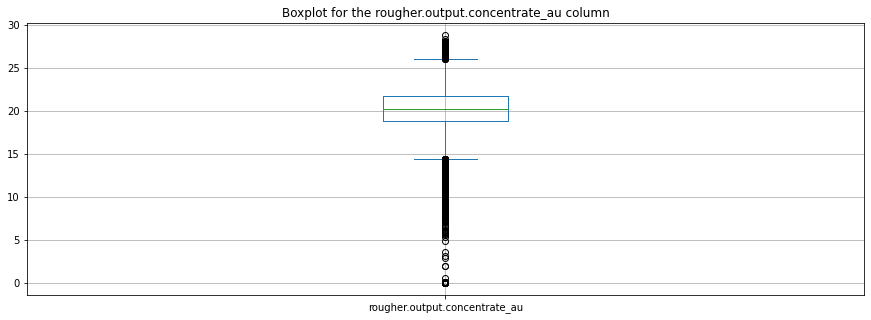

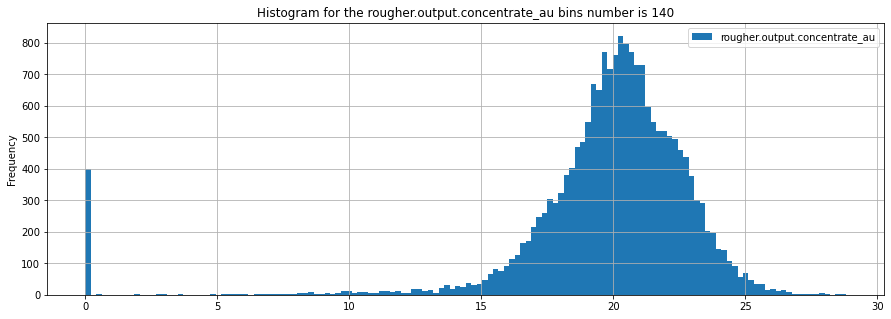

count    19439.000000
mean        19.772000
std          3.753600
min          0.000000
25%         18.802523
50%         20.280214
75%         21.717843
max         28.824507
Name: rougher.output.concentrate_au, dtype: float64

0.000000     394
13.791368     11
20.341888      6
18.652372      6
0.010000       5
            ... 
21.864280      1
22.866433      1
22.400279      1
22.630948      1
17.804134      1
Name: rougher.output.concentrate_au, Length: 19015, dtype: int64

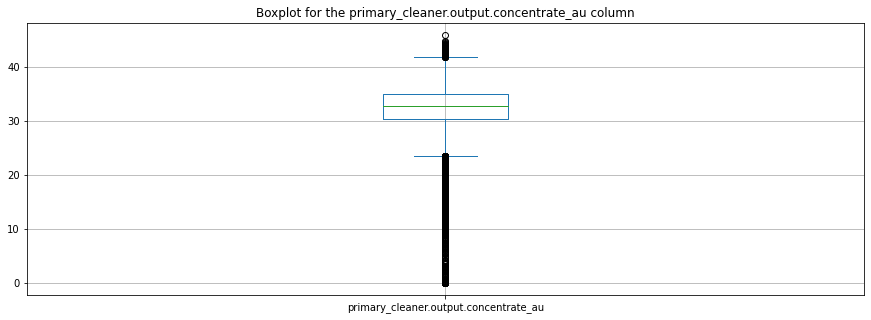

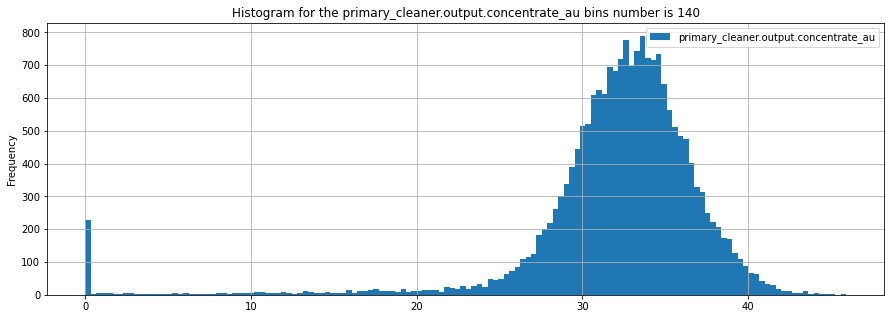

count    19439.000000
mean        32.119400
std          5.627611
min          0.000000
25%         30.463140
50%         32.841295
75%         35.048006
max         45.933934
Name: primary_cleaner.output.concentrate_au, dtype: float64

0.010000     117
0.000000     108
30.350809      6
27.765463      5
36.306431      5
            ... 
28.520419      1
31.176256      1
31.561684      1
31.404985      1
30.356618      1
Name: primary_cleaner.output.concentrate_au, Length: 19199, dtype: int64

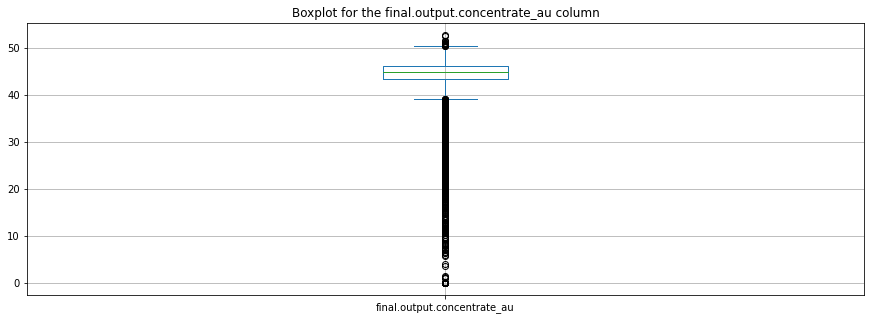

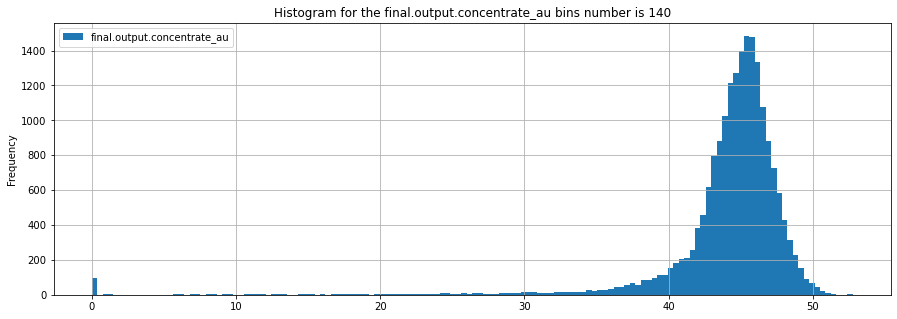

count    19439.000000
mean        44.076513
std          5.129784
min          0.000000
25%         43.402215
50%         45.011244
75%         46.275313
max         52.756638
Name: final.output.concentrate_au, dtype: float64

0.000000     98
37.336849    11
44.528214     7
46.105030     6
42.527939     5
             ..
46.010461     1
45.983578     1
45.109965     1
46.386971     1
46.299438     1
Name: final.output.concentrate_au, Length: 19308, dtype: int64

In [11]:
# Let's analyze the concentration of gold at each stage.
parameters = [
    'rougher.output.concentrate_au', 
    'primary_cleaner.output.concentrate_au',          
    'final.output.concentrate_au'
]
for element in parameters:
    description(data, element)

**Gold**  

At all stages, the gold concentration values are normally distributed. In each distribution, there is an anomaly in the form of peaks at zero values (as is the case with silver and lead). It can be assumed that the appearance of zeros is justified and due to the continuity of the ore enrichment process. For example, at the time of taking readings, a new batch of raw material simply has not yet gone through the flotation process.
  
*Consider concentrations:*
* Flotation. Median gold concentration: 20.3%
* Primary cleaning. Median gold concentration: 32.8%
* Final concentrate. Median gold concentration: 45%
  
There are practically no differences in lead concentration between the primary treatment and the final concentrate.

In [12]:
# Record the results in a table.
au_concentrate = pd.DataFrame(
    {
        'Flotation': [data['rougher.output.concentrate_au'].median()], 
        'Primary cleaning': [
            data['primary_cleaner.output.concentrate_au'].median()
        ], 
        'Final concentrate': [
            data['final.output.concentrate_au'].median()
        ]
    }, 
    index=[
        'Median gold concentration'
    ]
)
display(au_concentrate)

,Flotation,Primary cleaning,Final concentrate
Median gold concentration,20.280214,32.841295,45.011244


It can be concluded that with almost every stage of ore refining, the concentration of silver and lead decreases, while that of gold increases.
  
Next, consider the distribution of raw material granule sizes on the training and test samples. Let's see if they differ, and if so, by how much.

### Comparison of the size distribution of raw material granules on the training and test samples

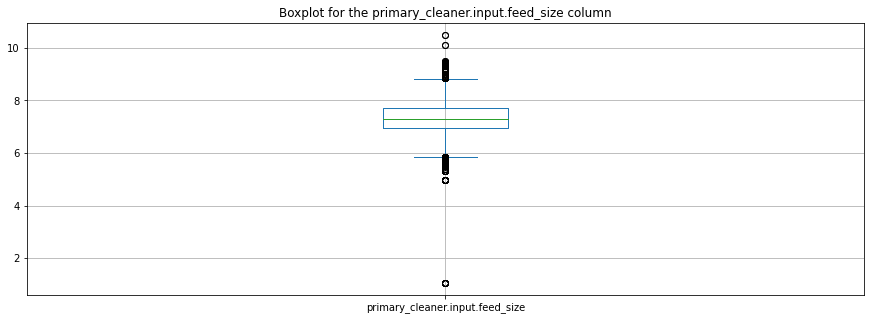

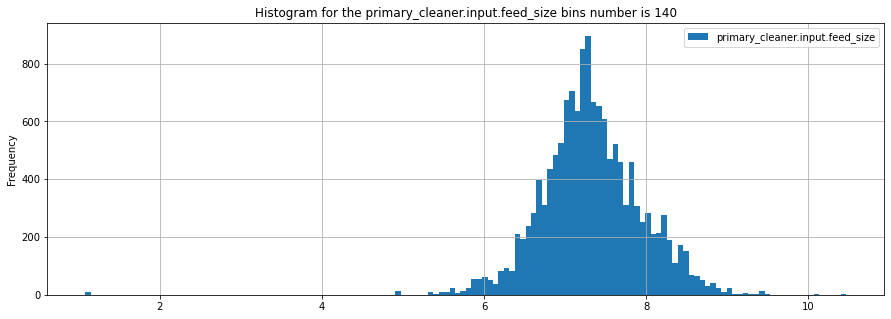

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

7.250000    312
7.000000    210
7.300000    204
7.700000    158
7.280000    144
           ... 
7.580000      1
7.996666      1
7.900000      1
7.895667      1
6.283333      1
Name: primary_cleaner.input.feed_size, Length: 3732, dtype: int64

In [13]:
# Let's analyze the size distribution of raw material granules
# at the flotation entry stage.
# Loop through our description function
# training and test sets.
description(train_data, 'primary_cleaner.input.feed_size')

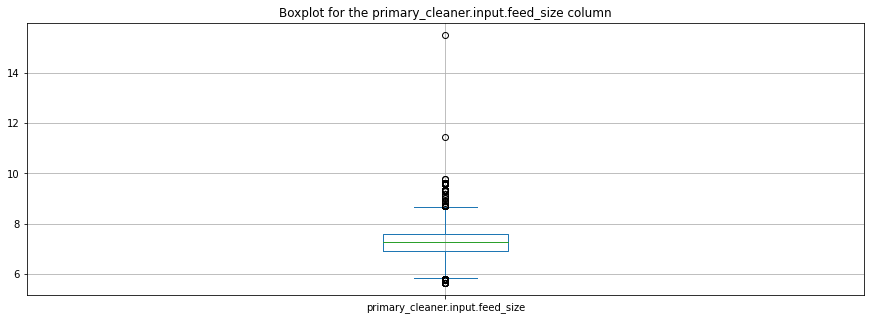

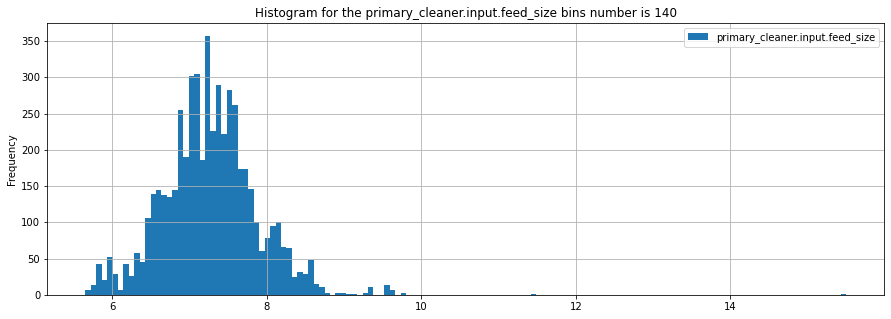

count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

7.200000    124
7.100000     87
7.530000     77
7.830000     68
7.250000     65
           ... 
7.390000      1
7.400000      1
8.260000      1
7.580000      1
7.966666      1
Name: primary_cleaner.input.feed_size, Length: 1537, dtype: int64

In [14]:
# Now the test set.
description(test_data, 'primary_cleaner.input.feed_size')

In both cases, we see a normal distribution. The medians are approximately equal and are about 7.3. Outliers do not greatly affect the difference between distributions.
The next step is to analyze the total concentrations of all substances at different stages.

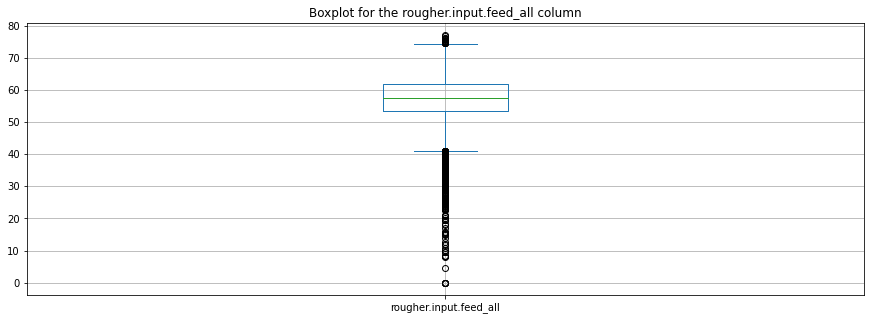

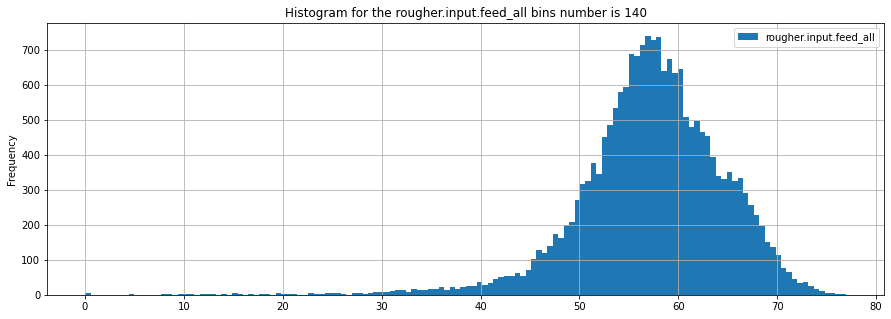

count    19439.000000
mean        57.320789
std          7.212680
min          0.040000
25%         53.557679
50%         57.594391
75%         61.953459
max         76.978947
Name: rougher.input.feed_all, dtype: float64

58.253792    10
60.283906     6
57.427033     5
0.040000      5
59.496087     5
             ..
57.596278     1
58.543492     1
59.199126     1
57.504092     1
53.535054     1
Name: rougher.input.feed_all, Length: 19409, dtype: int64

In [15]:
# Investigate the total concentration of all substances of raw materials.
data['rougher.input.feed_all'] = (
    data['rougher.input.feed_ag'] +
    data['rougher.input.feed_pb'] +
    data['rougher.input.feed_au'] +
    data['rougher.input.feed_sol']
)

description(data, 'rougher.input.feed_all')

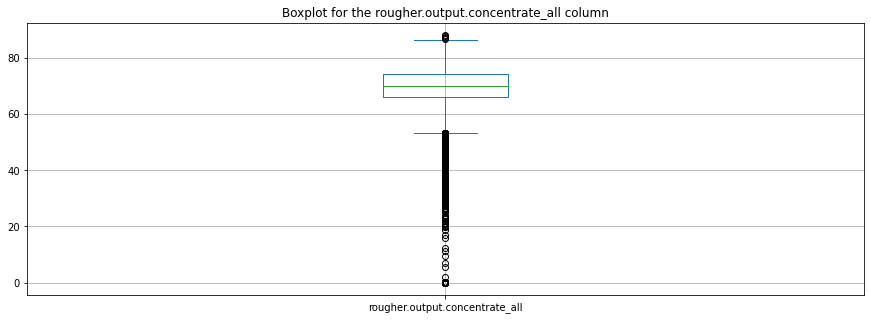

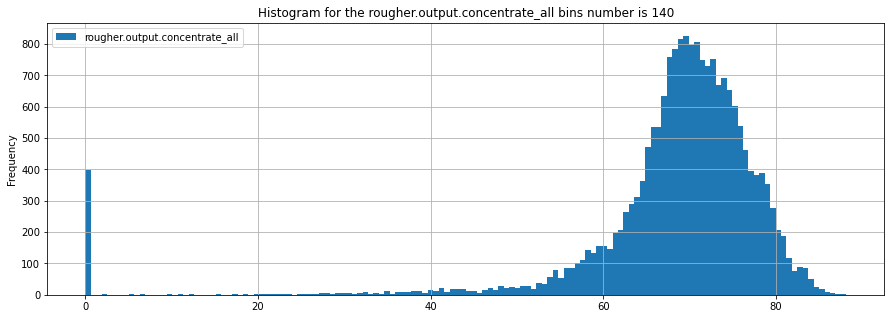

count    19439.000000
mean        68.170865
std         12.491279
min          0.000000
25%         66.012495
50%         70.181495
75%         74.356904
max         88.140119
Name: rougher.output.concentrate_all, dtype: float64

0.000000     394
41.115844     11
72.423889      6
67.824055      6
0.040000       5
            ... 
65.712260      1
67.246265      1
65.507211      1
66.736131      1
69.544003      1
Name: rougher.output.concentrate_all, Length: 19015, dtype: int64

In [16]:
# Investigate the total concentration of all substances in the crude concentrate.
data['rougher.output.concentrate_all'] = (
    data['rougher.output.concentrate_ag'] +
    data['rougher.output.concentrate_pb'] +
    data['rougher.output.concentrate_au'] +
    data['rougher.output.concentrate_sol']
)

description(data, 'rougher.output.concentrate_all')

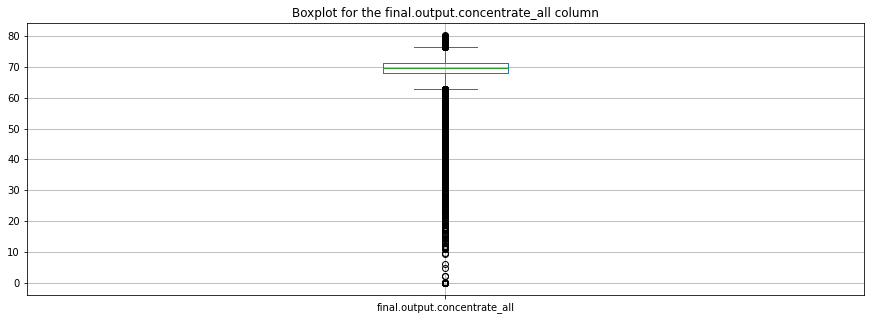

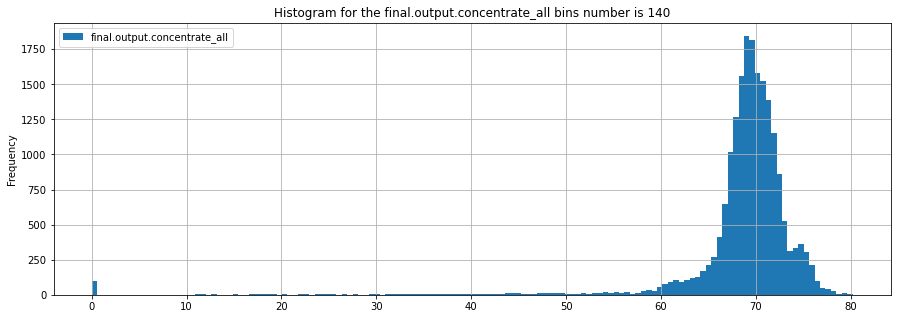

count    19439.000000
mean        68.653624
std          7.427536
min          0.000000
25%         67.932362
50%         69.598444
75%         71.368472
max         80.210644
Name: final.output.concentrate_all, dtype: float64

0.000000     98
64.690452    11
74.112068     7
69.425969     6
67.946259     5
             ..
71.630541     1
71.571243     1
71.307466     1
72.269132     1
68.353154     1
Name: final.output.concentrate_all, Length: 19308, dtype: int64

In [17]:
# Investigate the total concentration of all substances in the final concentrate.
data['final.output.concentrate_all'] = (
    data['final.output.concentrate_ag'] +
    data['final.output.concentrate_pb'] +
    data['final.output.concentrate_au'] +
    data['final.output.concentrate_sol']
)

description(data, 'final.output.concentrate_all')

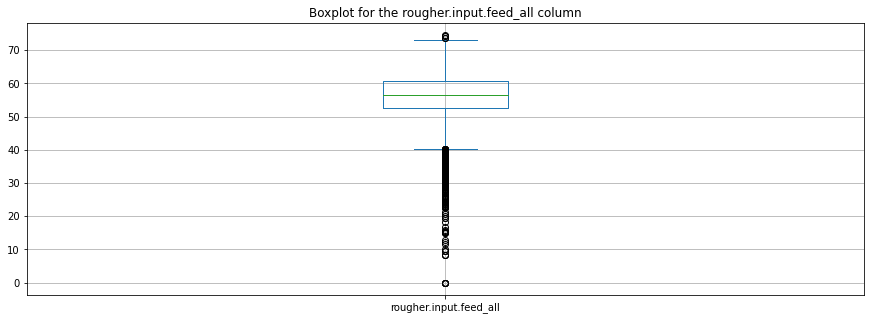

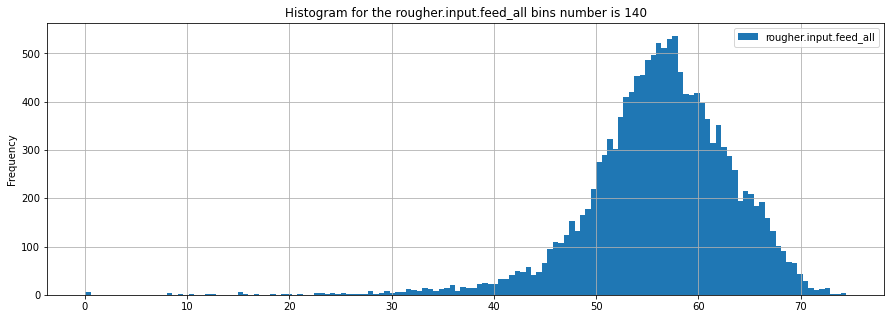

count    14149.000000
mean        56.242170
std          7.029808
min          0.040000
25%         52.573579
50%         56.627635
75%         60.763234
max         74.458253
Name: rougher.input.feed_all, dtype: float64

58.253792    10
0.040000      5
59.496087     5
57.427033     5
56.928130     3
             ..
53.639594     1
53.868431     1
53.890454     1
53.041768     1
53.535054     1
Name: rougher.input.feed_all, Length: 14126, dtype: int64

In [18]:
# Now do the same with the training set
# We investigate the total concentration of all substances of raw materials
# in the training set.
train_data['rougher.input.feed_all'] = (
    train_data['rougher.input.feed_ag'] +
    train_data['rougher.input.feed_pb'] +
    train_data['rougher.input.feed_au'] +
    train_data['rougher.input.feed_sol']
)

description(train_data, 'rougher.input.feed_all')

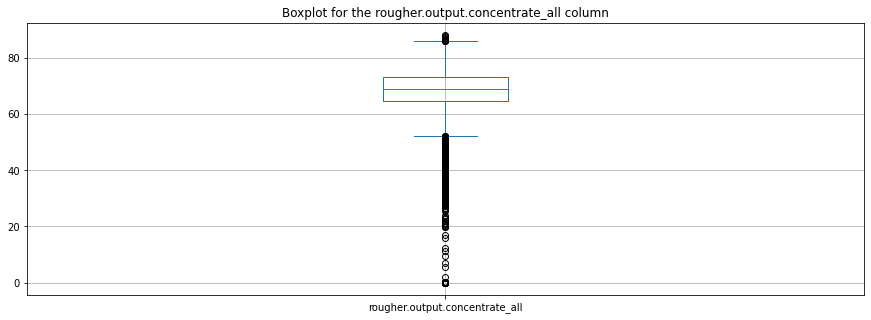

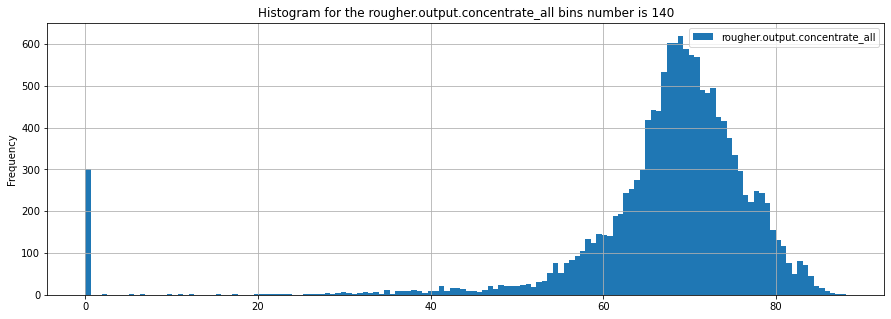

count    14149.000000
mean        67.173145
std         12.713129
min          0.000000
25%         64.914390
50%         69.175663
75%         73.429261
max         88.140119
Name: rougher.output.concentrate_all, dtype: float64

0.000000     297
41.115844     11
72.423889      6
0.040000       5
62.046453      4
            ... 
68.768197      1
69.217516      1
71.350789      1
70.987650      1
69.544003      1
Name: rougher.output.concentrate_all, Length: 13829, dtype: int64

In [19]:
# Investigate the total concentration of all substances in the crude concentrate
# in the training set.
train_data['rougher.output.concentrate_all'] = (
    train_data['rougher.output.concentrate_ag'] +
    train_data['rougher.output.concentrate_pb'] +
    train_data['rougher.output.concentrate_au'] +
    train_data['rougher.output.concentrate_sol']
)

description(train_data, 'rougher.output.concentrate_all')

### Study of the total concentration of all substances at different stages

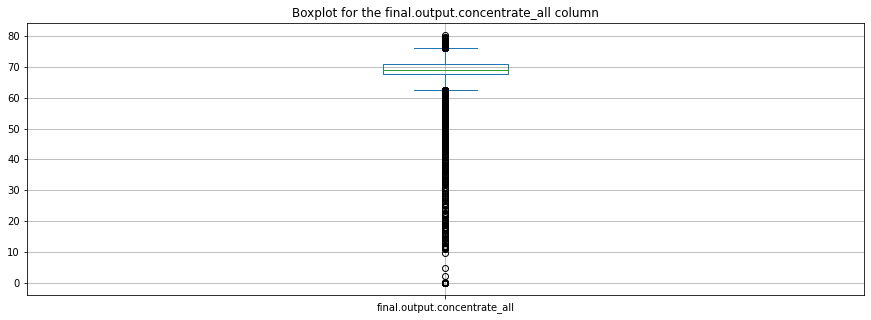

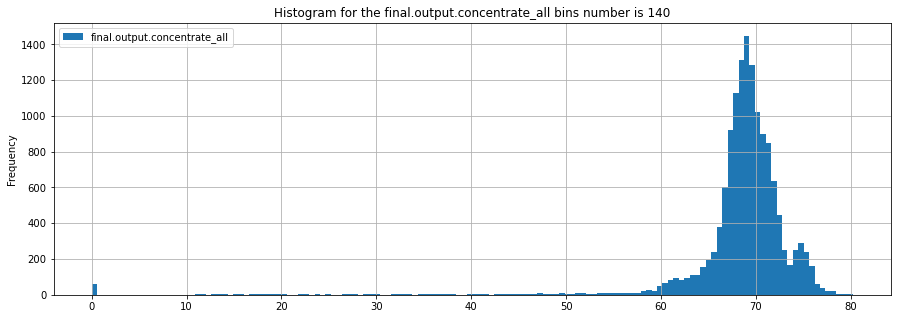

count    14149.000000
mean        68.387872
std          7.023723
min          0.000000
25%         67.559819
50%         69.141502
75%         70.974661
max         80.210644
Name: final.output.concentrate_all, dtype: float64

0.000000     58
64.690452    11
74.112068     7
68.805134     5
67.946259     5
             ..
73.897632     1
73.938700     1
74.489149     1
74.522659     1
68.353154     1
Name: final.output.concentrate_all, Length: 14065, dtype: int64

In [20]:
# Investigate the total concentration of all substances in the final concentrate
# in the training set.
train_data['final.output.concentrate_all'] = (
    train_data['final.output.concentrate_ag'] +
    train_data['final.output.concentrate_pb'] +
    train_data['final.output.concentrate_au'] +
    train_data['final.output.concentrate_sol']
)

description(train_data, 'final.output.concentrate_all')

Some machine learning algorithms are sensitive to the range and distribution of values in a data set. Data outliers can mess up and mislead the training process, leading to longer training times, less accurate models, and ultimately worse results. Let's get rid of outliers in the training sample that are outside the "whiskers".

In [21]:
# Let's create a function that allows you to exclude data from the sample,
# lying outside the "whiskers".

def iqr_cut (data,column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered_data = data[
        (data[column] >= lower) 
        & 
        (data[column] <= upper)
    ]
    return filtered_data

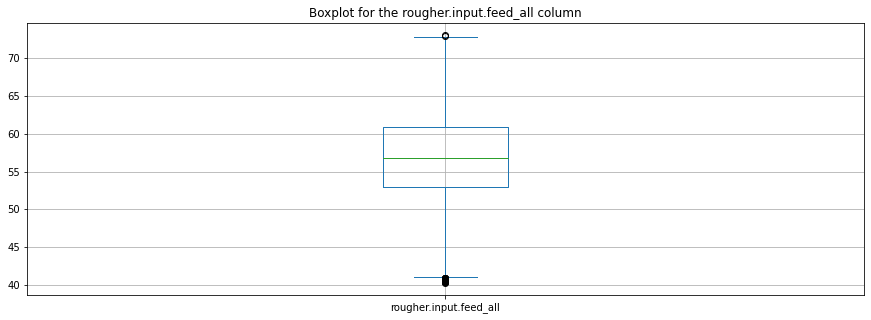

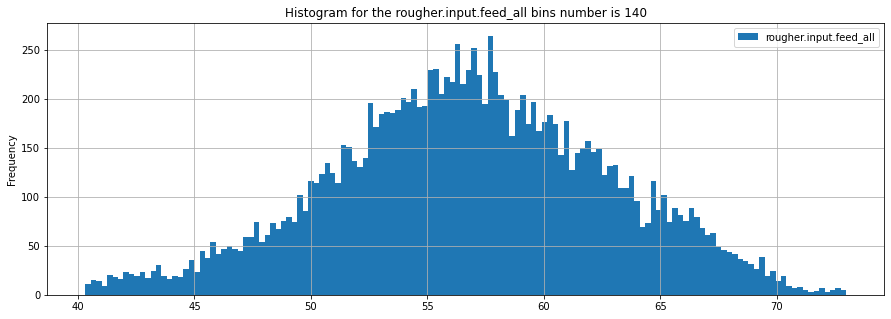

count    13803.000000
mean        56.811298
std          5.941147
min         40.316082
25%         52.927205
50%         56.793253
75%         60.901397
max         72.993238
Name: rougher.input.feed_all, dtype: float64

58.253792    10
57.427033     5
59.496087     5
56.928130     3
57.002331     1
             ..
55.262839     1
41.843899     1
55.400429     1
51.296961     1
53.535054     1
Name: rougher.input.feed_all, Length: 13784, dtype: int64

In [22]:
# Remove outliers of the total concentration of substances,
# encountered before the start of flotation.
filtered_train_data_rougher_input = iqr_cut(train_data, 
                                            'rougher.input.feed_all')
# Check the updated training set.
description(filtered_train_data_rougher_input, 
            'rougher.input.feed_all')

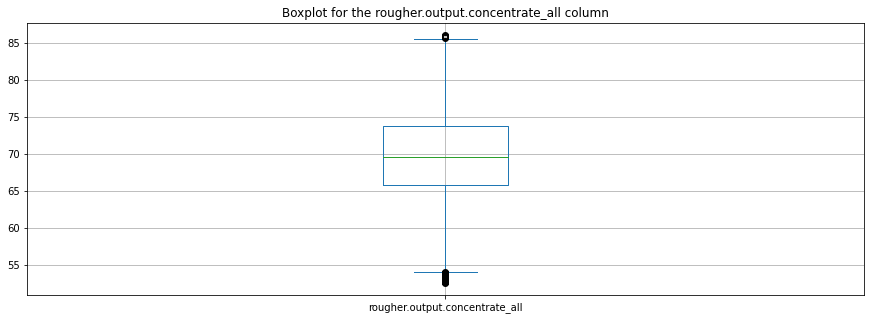

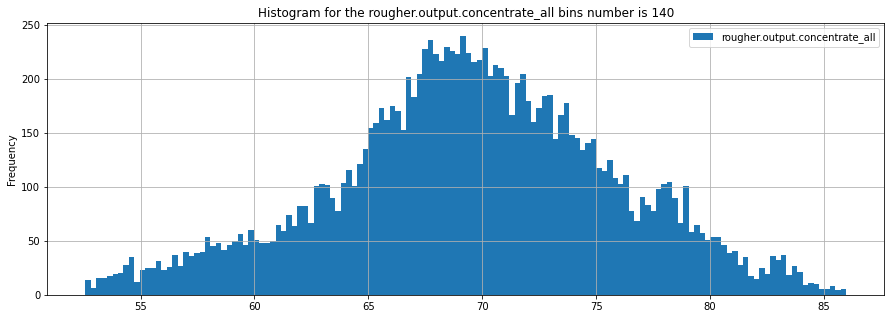

count    13144.000000
mean        69.561014
std          6.219405
min         52.575475
25%         65.789436
50%         69.580311
75%         73.678481
max         85.980989
Name: rougher.output.concentrate_all, dtype: float64

72.423889    6
62.046453    4
69.637081    3
66.424950    1
70.112187    1
            ..
81.154576    1
80.703295    1
78.710551    1
76.726015    1
69.544003    1
Name: rougher.output.concentrate_all, Length: 13134, dtype: int64

In [23]:
# Remove outliers of the total concentration of substances,
# encountered before the start of flotation.
filtered_train_data_rougher_output = iqr_cut(
    filtered_train_data_rougher_input, 
    'rougher.output.concentrate_all'
)
# Check the updated training set.
description(filtered_train_data_rougher_output, 
            'rougher.output.concentrate_all')

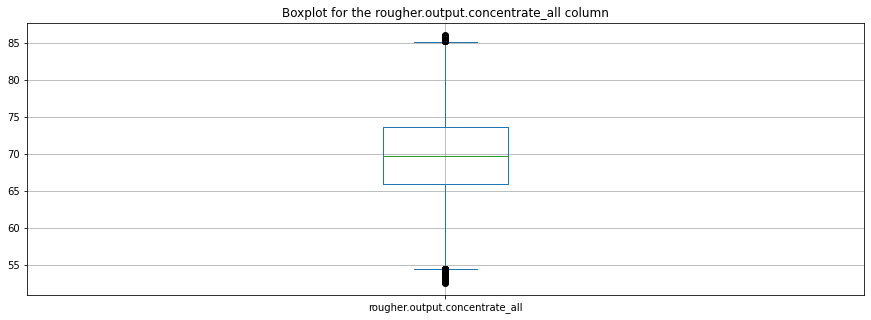

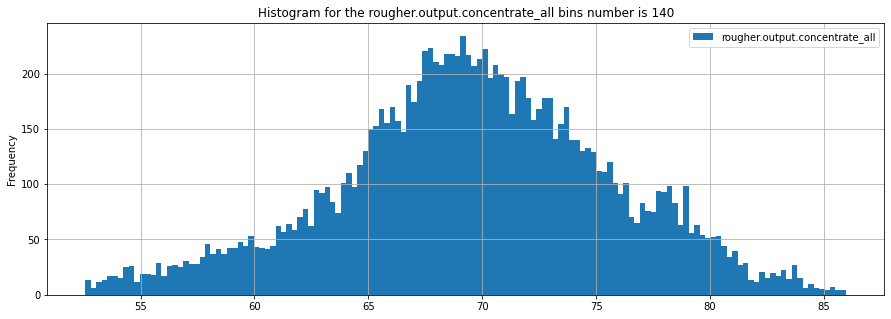

count    12339.000000
mean        69.607597
std          6.037126
min         52.575475
25%         65.927554
50%         69.628832
75%         73.593770
max         85.980989
Name: rougher.output.concentrate_all, dtype: float64

72.423889    6
62.046453    4
69.637081    3
70.468986    1
68.460569    1
            ..
75.894455    1
74.774187    1
73.726160    1
74.040615    1
69.544003    1
Name: rougher.output.concentrate_all, Length: 12329, dtype: int64

In [24]:
# Also get rid of outliers at the stage of the final product.
filtered_train_data_final_output = iqr_cut(
    filtered_train_data_rougher_output, 
    'final.output.concentrate_all'
)
# Check the updated training set.
description(filtered_train_data_final_output, 
            'rougher.output.concentrate_all')

In [25]:
# Create a new variable.
fltrd_train_data = filtered_train_data_final_output

### Conclusion

We considered the concentrations of each metal at each stage of ore enrichment. It was found that with each stage of enrichment, the concentration of gold increases, the concentration of other metals decreases.
The results are presented in the table.

In [26]:
conc_results = pd.concat([ag_concentrate, pb_concentrate, au_concentrate])
display(conc_results)

,Flotation,Primary cleaning,Final concentrate,Final Concentrate
Median silver concentration,12.098115,8.507298,5.066039,NaN
Median plumbum concentration,7.742580,10.142270,NaN,10.102264
Median gold concentration,20.280214,32.841295,45.011244,NaN


Each distribution has an anomaly in the form of peaks at zero values. It can be assumed that the appearance of zeros is justified and due to the continuity of the ore enrichment process. For example, at the time of taking readings, a new batch of raw material simply has not yet gone through the flotation process.

We considered the distributions of raw material granule sizes on the training and test sets and recognized that the distributions are almost the same.

We also considered the distribution of the total concentrations of all substances at all stages of enrichment in the training set. It was decided to get rid of outliers in order to ensure a high-quality learning process for the future mathematical model. The processed training sample is stored in the fltrd_train_data variable.

The next steps will be:
1. Creating a function for calculating the final sMAPE
2. Determining the correlation between target features and other features
3. Standardization of training set features
4. Train and validate multiple models
5. Choosing the best model, checking its quality on a test set

## Create a function to calculate the final sMAPE

In [27]:
# Create a function to calculate sMAPE.
# Function parameters will be correct answers and predictions.
def smape(predictions, target, **kwargs):
    smape = ((abs(target - predictions)) / 
             ((abs(target) + abs(predictions)) / 2)).sum() / len(target)
    return smape

## Training different models and testing their quality by cross-validation. Choose the best model

In [28]:
# Determine the features that most strongly affect the target features.
# Let's start with rougher.output.recovery.
# Create a column slice for analysis.
fltrd_train_data_corrs_rougher = fltrd_train_data[[
    'rougher.output.recovery',                                       
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air',
    'rougher.state.floatbank10_f_level'
]]
correlations = fltrd_train_data_corrs_rougher.corr()
display(correlations.loc['rougher.output.recovery'].
        sort_values(ascending=False))

rougher.output.recovery               1.000000
rougher.state.floatbank10_a_air       0.434896
rougher.input.feed_ag                 0.388153
rougher.state.floatbank10_a_level     0.372045
rougher.input.feed_pb                 0.361048
rougher.input.feed_au                 0.337851
rougher.input.floatbank10_xanthate    0.292072
rougher.input.feed_sol                0.282495
rougher.input.floatbank11_xanthate    0.259143
rougher.input.feed_size               0.129785
rougher.input.feed_rate               0.020574
rougher.input.floatbank11_sulfate    -0.089298
rougher.input.floatbank10_sulfate    -0.103946
rougher.state.floatbank10_f_air      -0.144513
rougher.state.floatbank10_e_level    -0.214211
rougher.state.floatbank10_e_air      -0.214779
rougher.state.floatbank10_c_level    -0.216039
rougher.state.floatbank10_f_level    -0.216446
rougher.state.floatbank10_d_level    -0.216623
rougher.state.floatbank10_b_level    -0.217651
rougher.state.floatbank10_b_air      -0.275242
rougher.state

In [29]:
# Now check the feature correlation with
# target feature final.output.recovery.
fltrd_train_data_corrs_final = fltrd_train_data[[
    'final.output.recovery',
    'primary_cleaner.input.sulfate',
    'primary_cleaner.input.depressant',
    'primary_cleaner.input.feed_size',
    'primary_cleaner.input.xanthate',
    'primary_cleaner.state.floatbank8_a_air',
    'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_b_air',
    'primary_cleaner.state.floatbank8_b_level',
    'primary_cleaner.state.floatbank8_c_air',
    'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_d_air',
    'primary_cleaner.state.floatbank8_d_level',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_air',
    'rougher.state.floatbank10_f_level',
    'secondary_cleaner.state.floatbank2_a_air',
    'secondary_cleaner.state.floatbank2_a_level',
    'secondary_cleaner.state.floatbank2_b_air',
    'secondary_cleaner.state.floatbank2_b_level',
    'secondary_cleaner.state.floatbank3_a_air',
    'secondary_cleaner.state.floatbank3_a_level',
    'secondary_cleaner.state.floatbank3_b_air',
    'secondary_cleaner.state.floatbank3_b_level',
    'secondary_cleaner.state.floatbank4_a_air',
    'secondary_cleaner.state.floatbank4_a_level',
    'secondary_cleaner.state.floatbank4_b_air',
    'secondary_cleaner.state.floatbank4_b_level',
    'secondary_cleaner.state.floatbank5_a_air',
    'secondary_cleaner.state.floatbank5_a_level',
    'secondary_cleaner.state.floatbank5_b_air',
    'secondary_cleaner.state.floatbank5_b_level',
    'secondary_cleaner.state.floatbank6_a_air',
    'secondary_cleaner.state.floatbank6_a_level'
]]
correlations = fltrd_train_data_corrs_final.corr()
display(correlations.loc['final.output.recovery'].sort_values(
    ascending=False
)
       )

final.output.recovery                         1.000000
primary_cleaner.input.sulfate                 0.363711
rougher.input.feed_ag                         0.347373
rougher.input.floatbank10_xanthate            0.341605
rougher.input.feed_au                         0.333007
rougher.input.floatbank11_xanthate            0.315974
rougher.state.floatbank10_a_air               0.245262
primary_cleaner.input.xanthate                0.230347
secondary_cleaner.state.floatbank4_a_air      0.218921
primary_cleaner.state.floatbank8_b_air        0.205570
secondary_cleaner.state.floatbank3_a_air      0.200925
primary_cleaner.state.floatbank8_c_air        0.198760
secondary_cleaner.state.floatbank4_b_air      0.192649
primary_cleaner.state.floatbank8_a_air        0.189817
rougher.input.feed_pb                         0.188905
rougher.input.feed_sol                        0.188857
secondary_cleaner.state.floatbank2_a_air      0.167063
secondary_cleaner.state.floatbank2_b_air      0.166407
primary_cl

Unfortunately, the `corr()` method does not reflect the evaluation of non-linear dependencies. Nevertheless, we may well begin the selection of influencing features based on the results of this method.
Let's take the Pearson coefficient 0.2 (modulo) for the target feature `rougher.output.recovery` as a threshold.
For the target feature `final.output.recovery`, let's take a threshold of 0.1 (modulo). Whatever else we leave. Anything less is removed.
  
There is a relationship between the target trait `rougher.output.recovery` and other traits:
  
  *Direct:*  
* `rougher.state.floatbank10_a_air`      
* `rougher.input.feed_ag`                
* `rougher.state.floatbank10_a_level`     
* `rougher.input.feed_pb`                
* `rougher.input.feed_au`                
* `rougher.input.floatbank10_xanthate`   
* `rougher.input.feed_sol`                
* `rougher.input.floatbank11_xanthate`   
  
*Inverse:*  
    
* `rougher.state.floatbank10_e_level`    
* `rougher.state.floatbank10_e_air`     
* `rougher.state.floatbank10_c_level`    
* `rougher.state.floatbank10_f_leve`  
* `rougher.state.floatbank10_d_level`   
* `rougher.state.floatbank10_b_level`    
* `rougher.state.floatbank10_b_air`     
* `rougher.state.floatbank10_d_air`      
* `rougher.state.floatbank10_c_air`       
  
We use these as `features` features for our model that predicts `rougher.output.recovery` values.
  
There is a relationship between the target attribute `final.output.recovery` and other attributes:
  
*Direct:*  

* `primary_cleaner.input.sulfate`
* `rougher.input.feed_ag`
* `rougher.input.floatbank10_xanthate`
* `rougher.input.feed_au`
* `rougher.input.floatbank11_xanthate`
* `rougher.state.floatbank10_a_air`
* `primary_cleaner.input.xanthate`
* `secondary_cleaner.state.floatbank4_a_air`
* `primary_cleaner.state.floatbank8_b_air`
* `secondary_cleaner.state.floatbank3_a_air`
* `primary_cleaner.state.floatbank8_c_air`
* `secondary_cleaner.state.floatbank4_b_air`
* `primary_cleaner.state.floatbank8_a_air`
* `rougher.input.feed_pb`
* `rougher.input.feed_sol`
* `secondary_cleaner.state.floatbank2_a_air`
* `secondary_cleaner.state.floatbank2_b_air`
* `primary_cleaner.input.depressant`
* `rougher.input.feed_rate`
* `primary_cleaner.state.floatbank8_a_level`
* `primary_cleaner.state.floatbank8_c_level`
* `primary_cleaner.state.floatbank8_b_level`
  
*Inverse:*  
  
* `secondary_cleaner.state.floatbank4_b_level`
* `rougher.state.floatbank10_b_air`
* `rougher.state.floatbank10_d_air`
* `rougher.state.floatbank10_c_air`

We use them as `features` features for our model that predicts `final.output.recovery` values. 

### Target feature rougher.output.recovery

In [30]:
# Prepare features and target feature for
# predictions rougher.output.recovery.
features_rougher = fltrd_train_data[[                                       
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',
    'rougher.input.floatbank10_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_level',
    'rougher.input.floatbank11_xanthate'
]]
target_rougher = fltrd_train_data['rougher.output.recovery']

Note that feature standardization does not make sense for decision trees. But we will carry it out anyway, since we will also use linear regression.

In [31]:
# Standardize numerical quantitative features
# of the training set.
scaler = StandardScaler()
features_rougher = pd.DataFrame(
    scaler.fit_transform(features_rougher),
    columns = features_rougher.columns
)

#### Random forest

In [32]:
# Choose the best model for predicting rougher.output.recovery
# Train a random forest model and check its quality by cross-validation,
# selecting various hyperparameters. Let's start with the maximum depth of the trees.
for depth in range(1, 16, 1):
    model = RandomForestRegressor(
        n_estimators=20, 
        max_depth=depth, 
        random_state=12345
    )
    my_scorer = make_scorer(smape, greater_is_better=False)
    scores = abs(cross_val_score(
    model, 
    features_rougher, 
    target_rougher, 
    scoring=my_scorer, 
    cv=10
    ))
    final_score = scores.mean()
    print('depth =',depth, 'Average sMAPE is', final_score)

depth = 1 Average sMAPE is 0.07074513025617649
depth = 2 Average sMAPE is 0.06425639759762096
depth = 3 Average sMAPE is 0.0569681099394869
depth = 4 Average sMAPE is 0.05748411851916101
depth = 5 Average sMAPE is 0.05847914684056306
depth = 6 Average sMAPE is 0.058738077935750845
depth = 7 Average sMAPE is 0.05845276871854347
depth = 8 Average sMAPE is 0.05858067206701643
depth = 9 Average sMAPE is 0.05943833970117355
depth = 10 Average sMAPE is 0.059732823561576484
depth = 11 Average sMAPE is 0.060211645142453654
depth = 12 Average sMAPE is 0.060612163380434056
depth = 13 Average sMAPE is 0.060760018826154304
depth = 14 Average sMAPE is 0.06089898207196006
depth = 15 Average sMAPE is 0.06158616297270608


In [33]:
# The maximum tree depth of 3 proved to be the best.
# Now select the number of estimators.
for estimators in range(10, 110, 10):
    model = RandomForestRegressor(
        n_estimators=estimators, 
        max_depth=3, 
        random_state=12345
    )
    my_scorer = make_scorer(smape, greater_is_better=False)
    scores = abs(cross_val_score(
    model, 
    features_rougher, 
    target_rougher, 
    scoring=my_scorer, 
    cv=10
    ))
    final_score = scores.mean()
    print('n_estimators =', estimators, 'Average sMAPE is',
          final_score)

n_estimators = 10 Average sMAPE is 0.05658492927648402
n_estimators = 20 Average sMAPE is 0.0569681099394869
n_estimators = 30 Average sMAPE is 0.05703375023606041
n_estimators = 40 Average sMAPE is 0.05705232254689572
n_estimators = 50 Average sMAPE is 0.05701568435053463
n_estimators = 60 Average sMAPE is 0.0569570634163287
n_estimators = 70 Average sMAPE is 0.0569221355467134
n_estimators = 80 Average sMAPE is 0.056875848932979624
n_estimators = 90 Average sMAPE is 0.05684519044671364
n_estimators = 100 Average sMAPE is 0.0569156870558077


In [34]:
# The number of estimators equal to 10 performed best.
# Fix the result.
model_rougher_rf = RandomForestRegressor(
    n_estimators=10, 
    max_depth=3, 
    random_state=12345
)
my_scorer = make_scorer(smape, greater_is_better=False)
scores = abs(cross_val_score(
    model_rougher_rf, 
    features_rougher, 
    target_rougher, 
    scoring=my_scorer, 
    cv=10
    ))
final_score = scores.mean()
print(
    'Average sMAPE of the random forest model is {:.2%}'.format(final_score))
rougher_rf_smape = final_score

Average sMAPE of the random forest model is 5.66%


#### Linear Regression

In [35]:
# Train a linear regression model and check its quality by cross-validation.
model_rougher_lr = LinearRegression()
my_scorer = make_scorer(smape, greater_is_better=False)
scores = abs(cross_val_score(
    model_rougher_lr, 
    features_rougher, 
    target_rougher, 
    scoring=my_scorer, 
    cv=10
    ))
final_score = scores.mean()
print(
    'Average sMAPE of the linear regression model is {:.2%}'.format(final_score))
rougher_lr_smape = final_score

Average sMAPE of the linear regression model is 6.04%


#### Decision Tree

In [36]:
# Train the decision tree model and check its quality by cross-validation.
# Let's choose the maximum depth of the trees.
for depth in range(1, 16, 1):
    model = DecisionTreeRegressor(
        max_depth=depth, 
        random_state=12345
    )
    my_scorer = make_scorer(smape, greater_is_better=False)
    scores = abs(cross_val_score(
    model, 
    features_rougher, 
    target_rougher, 
    scoring=my_scorer, 
    cv=10
    ))
    final_score = scores.mean()
    print('depth =',depth, 'Average sMAPE is', final_score)

depth = 1 Average sMAPE is 0.07101198194533857
depth = 2 Average sMAPE is 0.0661623653412378
depth = 3 Average sMAPE is 0.05759543364335131
depth = 4 Average sMAPE is 0.05907047617978702
depth = 5 Average sMAPE is 0.061126953166756884
depth = 6 Average sMAPE is 0.06553296701153818
depth = 7 Average sMAPE is 0.06417782659626897
depth = 8 Average sMAPE is 0.06509059929270002
depth = 9 Average sMAPE is 0.06582460770073476
depth = 10 Average sMAPE is 0.06463930521800618
depth = 11 Average sMAPE is 0.06698987700215035
depth = 12 Average sMAPE is 0.06896609577592931
depth = 13 Average sMAPE is 0.07145040511025923
depth = 14 Average sMAPE is 0.07149531015697683
depth = 15 Average sMAPE is 0.07329964052631754


In [37]:
# The maximum tree depth of 3 performed best.
# Fix the result.
model_rougher_dt = DecisionTreeRegressor(
    max_depth=3, 
    random_state=12345
)
my_scorer = make_scorer(smape, greater_is_better=False)
scores = abs(cross_val_score(
    model_rougher_dt, 
    features_rougher, 
    target_rougher, 
    scoring=my_scorer, 
    cv=10
    ))
final_score = scores.mean()
print(
    'Average sMAPE of the decision tree model is {:.2%}'.format(final_score))
rougher_dt_smape = final_score

Average sMAPE of the decision tree model is 5.76%


### Target feature final.output.recovery

In [38]:
# Prepare features and target feature
# to predict final.output.recovery.
features_final = fltrd_train_data[[
    'primary_cleaner.input.sulfate',
    'rougher.input.feed_ag',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.feed_au',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'primary_cleaner.input.xanthate',
    'secondary_cleaner.state.floatbank4_a_air',
    'primary_cleaner.state.floatbank8_b_air',
    'secondary_cleaner.state.floatbank3_a_air',
    'primary_cleaner.state.floatbank8_c_air',
    'secondary_cleaner.state.floatbank4_b_air',
    'primary_cleaner.state.floatbank8_a_air',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
    'secondary_cleaner.state.floatbank2_a_air',
    'secondary_cleaner.state.floatbank2_b_air',
    'primary_cleaner.input.depressant',
    'rougher.input.feed_rate',
    'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_b_level',
    'secondary_cleaner.state.floatbank4_b_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_c_air',
]]
target_final = fltrd_train_data['final.output.recovery']

In [39]:
# Standardize the numerical quantitative features of the training sample.
scaler = StandardScaler()
features_final = pd.DataFrame(
    scaler.fit_transform(features_final),
    columns = features_final.columns
)

#### Random forest

In [40]:
# Let's choose the best model for prediction final.output.recovery
# Train a random forest model and check its quality by cross-validation,
# selecting various hyperparameters. Let's start with the maximum depth of the trees.
for depth in range(1, 16, 1):
    model = RandomForestRegressor(
        n_estimators=20, 
        max_depth=depth, 
        random_state=12345
    )
    my_scorer = make_scorer(smape, greater_is_better=False)
    scores = abs(cross_val_score(
    model, 
    features_final, 
    target_final, 
    scoring=my_scorer, 
    cv=5
    ))
    final_score = scores.mean()
    print('depth =',depth, 'Average sMAPE is', final_score)

depth = 1 Average sMAPE is 0.08741286897412064
depth = 2 Average sMAPE is 0.08671923525847072
depth = 3 Average sMAPE is 0.08577589326929502
depth = 4 Average sMAPE is 0.08397767761699208
depth = 5 Average sMAPE is 0.08408747313895833
depth = 6 Average sMAPE is 0.08488968157290361
depth = 7 Average sMAPE is 0.08636398077127563
depth = 8 Average sMAPE is 0.08710925041241671
depth = 9 Average sMAPE is 0.0869033668989645
depth = 10 Average sMAPE is 0.08724497972871799
depth = 11 Average sMAPE is 0.08820151311570386
depth = 12 Average sMAPE is 0.08766500127672795
depth = 13 Average sMAPE is 0.08910521633117952
depth = 14 Average sMAPE is 0.08877524935218825
depth = 15 Average sMAPE is 0.08903086965078927


In [41]:
# The maximum tree depth of 4 proved to be the best.
# Now select the number of estimators.
for estimators in range(10, 110, 10):
    model = RandomForestRegressor(
        n_estimators=estimators, 
        max_depth=4, 
        random_state=12345
    )
    my_scorer = make_scorer(smape, greater_is_better=False)
    scores = abs(cross_val_score(
    model, 
    features_final, 
    target_final,
    scoring=my_scorer, 
    cv=10
    ))
    final_score = scores.mean()
    print(
        'n_estimators =', estimators, 'Average sMAPE is', 
        final_score)

n_estimators = 10 Average sMAPE is 0.08313995556607884
n_estimators = 20 Average sMAPE is 0.08282005835682435
n_estimators = 30 Average sMAPE is 0.0827248751465931
n_estimators = 40 Average sMAPE is 0.08249553617425984
n_estimators = 50 Average sMAPE is 0.08230023253278983
n_estimators = 60 Average sMAPE is 0.08226139055724577
n_estimators = 70 Average sMAPE is 0.08226678642236
n_estimators = 80 Average sMAPE is 0.08225607572779772
n_estimators = 90 Average sMAPE is 0.08217189393963122
n_estimators = 100 Average sMAPE is 0.0821820660443757


In [42]:
# The best number of estimators was 90.
# Fix the result.
model_final_rf = RandomForestRegressor(
    n_estimators=90, 
    max_depth=4, 
    random_state=12345
)
my_scorer = make_scorer(smape, greater_is_better=False)
scores = abs(cross_val_score(
    model_final_rf, 
    features_final, 
    target_final,
    scoring=my_scorer, 
    cv=10
    ))
final_score = scores.mean()
print(
    'Average sMAPE of the random forest model is {:.2%}'.format(final_score))
final_rf_smape = final_score

Average sMAPE of the random forest model is 8.22%


#### Linear regression

In [43]:
# Train a linear regression model and check its quality by cross-validation.
model_final_lr = LinearRegression()
my_scorer = make_scorer(smape, greater_is_better=False)
scores = abs(cross_val_score(
    model_final_lr, 
    features_final, 
    target_final,
    scoring=my_scorer, 
    cv=10
    ))
final_score = scores.mean()
print(
    'Average sMAPE of the linear regression model is {:.2%}'.format(final_score))
final_lr_smape = final_score

Average sMAPE of the linear regression model is 8.88%


#### Decision tree

In [44]:
# Train the decision tree model and check its quality by cross-validation.
# Let's choose the maximum depth of the trees.
for depth in range(1, 16, 1):
    model = DecisionTreeRegressor(
        max_depth=depth, 
        random_state=12345
    )
    my_scorer = make_scorer(smape, greater_is_better=False)
    scores = abs(cross_val_score(
    model, 
    features_final, 
    target_final, 
    scoring=my_scorer, 
    cv=10
    ))
    final_score = scores.mean()
    print('depth =',depth, 'Average sMAPE is', final_score)

depth = 1 Average sMAPE is 0.08588682046862849
depth = 2 Average sMAPE is 0.0882726195028254
depth = 3 Average sMAPE is 0.0880194579604236
depth = 4 Average sMAPE is 0.08690598954656636
depth = 5 Average sMAPE is 0.0913586950293634
depth = 6 Average sMAPE is 0.09291077936439597
depth = 7 Average sMAPE is 0.0970513630998307
depth = 8 Average sMAPE is 0.1056262776369
depth = 9 Average sMAPE is 0.10789444561198505
depth = 10 Average sMAPE is 0.10854558240151779
depth = 11 Average sMAPE is 0.11470997674702735
depth = 12 Average sMAPE is 0.12006924999474022
depth = 13 Average sMAPE is 0.12124516634233007
depth = 14 Average sMAPE is 0.12011100255634125
depth = 15 Average sMAPE is 0.13044120297165174


In [45]:
# The maximum depth of trees equal to 1 showed itself best.
# Fix the result.
model_final_dt = DecisionTreeRegressor(
    max_depth=1, 
    random_state=12345
)
my_scorer = make_scorer(smape, greater_is_better=False)
scores = abs(cross_val_score(
    model_final_dt, 
    features_final, 
    target_final, 
    scoring=my_scorer, 
    cv=10
    ))
final_score = scores.mean()
print(
    'Average sMAPE of the decision tree model is {:.2%}'.format(final_score))
final_dt_smape = final_score

Average sMAPE of the decision tree model is 8.59%


Based on the test results, the best models are:  
**rougher.output.recovery**  
Random forest model. sMAPE = 5.66%
    
**final.output.recovery**  
Random forest model. sMAPE = 8.22%

In [46]:
# Put the results in a table.
data_scores = pd.DataFrame(
    data={'Random forest': [rougher_rf_smape, final_rf_smape],
          'Linear regression': [rougher_lr_smape, final_lr_smape],
          'Decision Tree': [rougher_dt_smape, final_dt_smape]},
    index=['rougher.output.recovery','final.output.recovery'])
data_scores.index.name = 'Model'
display(data_scores)

,Random forest,Linear regression,Decision Tree
Model,,,
rougher.output.recovery,0.056585,0.060390,0.057595
final.output.recovery,0.082172,0.088829,0.085887


In [47]:
# Write a function to calculate the final sMAPE.
def final_smape(smape_rougher, smape_final):
    final_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return final_smape
# Let's summarize the results of the calculation on the training set.
print('Final sMAPE on the training set is {:.2%}'.
      format(final_smape
    (data_scores.loc['rougher.output.recovery'].min(),
     data_scores.loc['final.output.recovery'].min())))

Final sMAPE on the training set is 7.58%


Let's check the quality of these models on a test set. Let's calculate the final sMAPE.

In [48]:
# Check the quality on a test set.
# Prepare the correct answers.
# First for rougher.output.recovery.
test_target_rougher = data['rougher.output.recovery'].loc[test_data.index]
# Now for final.output.recovery.
test_target_final = data['final.output.recovery'].loc[test_data.index]
# Leave in the test set those features that
# we used for training.
test_features_rougher = test_data[[                                       
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',
    'rougher.input.floatbank10_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    'rougher.state.floatbank10_c_air',
    'rougher.state.floatbank10_c_level',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    'rougher.state.floatbank10_e_level',
    'rougher.state.floatbank10_f_level',
    'rougher.input.floatbank11_xanthate'
]]
# Prepare a test set for the final.output.recovery target feature.
test_features_final = test_data[[                                       
    'primary_cleaner.input.sulfate',
    'rougher.input.feed_ag',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.feed_au',
    'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'primary_cleaner.input.xanthate',
    'secondary_cleaner.state.floatbank4_a_air',
    'primary_cleaner.state.floatbank8_b_air',
    'secondary_cleaner.state.floatbank3_a_air',
    'primary_cleaner.state.floatbank8_c_air',
    'secondary_cleaner.state.floatbank4_b_air',
    'primary_cleaner.state.floatbank8_a_air',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
    'secondary_cleaner.state.floatbank2_a_air',
    'secondary_cleaner.state.floatbank2_b_air',
    'primary_cleaner.input.depressant',
    'rougher.input.feed_rate',
    'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_b_level',
    'secondary_cleaner.state.floatbank4_b_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_c_air'
]]

In [49]:
# Test the quality of our models.
# Let's start with the target feature rougher.output.recovery.
model_rougher = RandomForestRegressor(
    n_estimators=10, 
    max_depth=3, 
    random_state=12345
)
model_rougher.fit(features_rougher, target_rougher)
predictions_rougher = pd.Series(
    model_rougher.predict(test_features_rougher), 
    index=test_target_rougher.index
    )
smape_rougher = smape(predictions_rougher, test_target_rougher)
print('sMAPE of rougher.output.recovery is {:.2%}'.
      format(smape_rougher))

sMAPE of rougher.output.recovery is 9.91%


In [50]:
# Let's take a look at the feature_importances attribute to understand which features
# are most related to the target feature and which are least related.
def importance(model, features):
    importance = model.feature_importances_
    colums_features = features.columns 
    importance = pd.Series(importance, index=colums_features)
    importance.sort_values(ascending=False).plot(
        kind='bar', x=importance.index, y=importance,
        title='Feature importances bar chart'
    )

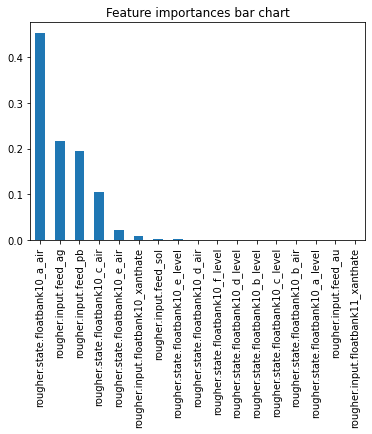

In [51]:
importance(model_rougher, test_features_rougher)

In [52]:
# Now the target feature is final.output.recovery.
model_final = RandomForestRegressor(
    n_estimators=90, 
    max_depth=4, 
    random_state=12345
)
model_final.fit(features_final, target_final)
predictions_final = pd.Series(
    model_final.predict(test_features_final), 
    index=test_target_final.index
    )
smape_final = smape(predictions_final, test_target_final)
print('sMAPE of rougher.output.recovery is {:.2%}'.
      format(smape_final))

sMAPE of rougher.output.recovery is 10.62%


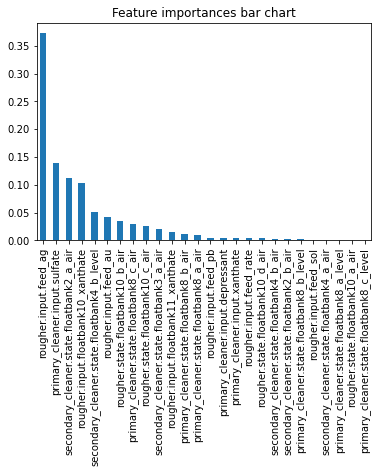

In [53]:
# Let's take a look at the feature_importances attribute to understand which features
# are most related to the target trait and which are least related.
importance(model_final, test_features_final)

In [54]:
# Calculate final sMAPE.
print('The final sMAPE of our model on the test set is {:.2%}'.
      format(final_smape(smape_rougher, smape_final)))

The final sMAPE of our model on the test set is 10.44%


### Conclusion

The final sMAPE is 10.44%.

## General conclusion

We prepared the data and analyzed it. As part of these steps, we studied the data, checked the correctness of the enrichment efficiency calculation, got rid of missing values and anomalies.  
In preparation for building models, we conducted a correlation analysis to identify the relationship between features and target features.  
Then, with the help of cross-validation, different types of models were tested, while adjusting their hyperparameters in parallel.
We achieved a final sMAPE value of 10.44%.